In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import csv
import os

In [2]:
class NeuralNetwork:

    def __init__(self, url):
        self.url = url
        self.data = None
        self.train_data = None
        self.test_data = None
        self.train_X = None
        self.train_Y = None

    def data_preprocessing(self):
        self.data = pd.read_csv(self.url)
        self.data.dropna(inplace=True)
        self.data.drop_duplicates(inplace=True)
        self.data.fillna(self.data.mean(), inplace=True)

    def calculate_correlation(self):
        corr = self.data.corr()
        correlation_outcome = corr['Results'].abs().sort_values(ascending=False)
        print(correlation_outcome)

        plt.figure(figsize=(14, 12))
        sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, cmap='coolwarm')
        plt.xticks(rotation=90, ha='center')
        plt.show()
        self.data = self.data.drop(['Cluster_ID', 'gamemode', 'gametype'], axis = 1)

    def split_data(self, test_size=0.2, random_state=42):
        self.train_data, self.test_data = train_test_split(self.data, test_size=test_size, random_state=random_state)

    def save_data(self):
        self.train_data.to_csv("dota_train.csv", index=False)
        self.test_data.to_csv("dota_test.csv", index=False)

    def load_training_data(self):
        train_url = 'https://raw.githubusercontent.com/YaswanthAdari/Gradient_descent_/main/dota_train.csv'
        test_url = 'https://raw.githubusercontent.com/YaswanthAdari/Gradient_descent_/main/dota_test.csv'

        df_train = pd.read_csv(train_url)
        self.train_Y = df_train['Results']
        self.train_X = df_train.drop(['Results', 'Cluster_ID', 'gamemode', 'gametype'], axis=1).values[:, :112]
#         self.train_X_predict = self.train_X
#         self.train_Y_predict = self.train_Y
        self.train_X = self.train_X.T
        self.train_Y = self.train_Y.to_numpy()

        df_test = pd.read_csv(test_url)
        self.test_Y = df_test['Results']
        self.test_X = df_test.drop(['Results', 'Cluster_ID', 'gamemode', 'gametype'], axis=1).values[:, :112]
        self.test_X = self.test_X.T
        self.test_Y = self.test_Y.to_numpy()

        #print(self.train_X)
       #print(self.train_Y)

        return self.train_X, self.train_Y, self.test_X, self.test_Y

    def activation_function(self, x, activation):

        if activation == "Sigmoid":
            z = 1/(1+np.exp(-x))
            return z

        if activation == "ReLU":
            z = np.maximum(0,x)
            return z

        if activation == "Leaky_ReLU":
            z = np.maximum(x*0.01, x)
            return z

        if activation == "Tanh":
            z = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
            return z

        else:
            raise ValueError("Invalid activation function specified.")

    def logistic_loss(self, a3, y):
        epsilon = 1e-15  # Small value to avoid taking the logarithm of zero
        m = y.shape[0]

        # Apply a clipping operation to keep a3 within a valid range
        a3 = np.clip(a3, epsilon, 1 - epsilon)

        # Compute the log probabilities
        logprobs = np.multiply(-np.log(a3), y) + np.multiply(-np.log(1 - a3), 1 - y)

        # Set invalid values (e.g., NaN or Inf) to zero
        logprobs = np.nan_to_num(logprobs)

        # Compute the overall loss
        loss = np.squeeze((1 / m) * np.sum(logprobs))

        return loss


    def RMSE(self, y_pred, y):
        mse = np.mean((y_pred - y) ** 2)
        rmse = np.sqrt(mse)
        return rmse


    def parameters_initialize(self, layer_dims, initializer):

        parameters = {}
        L = len(layer_dims)

        for l in range(1, L):
            if initializer == "Zero":
                parameters['W' + str(l)] = np.zeros((layer_dims[l], layer_dims[l-1]))
            elif initializer == "Random":
                parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
            elif initializer == "he-init":
                parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
            elif initializer == "Xavier":
                parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1 / layer_dims[l-1])
            else:
                raise ValueError("Invalid initializer specified")

            parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        return parameters

    def SGD(self, parameters, grads, learning_rate):
        L = len(parameters) // 2
        m = self.train_X.shape[1]  # Number of training examples

        for l in range(L):
            for i in range(m):
                # Randomly select a single training example index
                random_index = random.randint(0, m-1)

                # Update parameters using the gradients for the selected example
                parameters["W" + str(l+1)] = parameters['W' + str(l+1)] - learning_rate*grads['dW' + str(l+1)][:, random_index]
                parameters["b" + str(l+1)] = parameters['b' + str(l+1)] - learning_rate*grads['db' + str(l+1)][:, random_index]

        return parameters


    def GD(self, parameters, grads, learning_rate):

        L = len(parameters) // 2
        for l in range(L):
            parameters["W" + str(l+1)] = parameters['W' + str(l+1)] - learning_rate*grads['dW' + str(l+1)]
            parameters["b" + str(l+1)] = parameters['b' + str(l+1)] - learning_rate*grads['db' + str(l+1)]
        return parameters

    def adam(self, parameters, grads, v, s, t, learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):

        L = len(parameters) // 2
        v_corrected = {}
        s_corrected = {}

        for l in range(L):
            v["dW" + str(l+1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
            v["db" + str(l+1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]

            v_corrected["dW" + str(l+1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
            v_corrected["db" + str(l+1)] = v["db" + str(l + 1)] / (1 - np.power(beta1, t))

            s["dW" + str(l+1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
            s["db" + str(l+1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)

            s_corrected["dW" + str(l+1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
            s_corrected["db" + str(l+1)] = s["db" + str(l + 1)] / (1 - np.power(beta2, t))

            parameters["W" + str(l+1)] = parameters["W" + str(l + 1)] - learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + epsilon)
            parameters["b" + str(l+1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + epsilon)

        return parameters, v, s

    def forward_propagation(self, X, parameters, activation):

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        W3 = parameters["W3"]
        b3 = parameters["b3"]


        z1 = np.dot(W1, X) + b1
        a1 = self.activation_function(z1, activation)
        z2 = np.dot(W2, a1) + b2
        a2 = self.activation_function(z2, activation)
        z3 = np.dot(W3, a2) + b3
        a3 = self.activation_function(z3, activation)

        cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) # also add WL, bL, zL, aL if you are adding more layers

        return a3, cache

    def backward_propagation(self, X, Y, cache, activation, leaky_slope=0.01):
        m = X.shape[1]
        (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache

        dz3 = 1. / m * (a3 - Y)
        da2, dW3, db3 = self.linear_activation_backward(dz3, a2, W3, activation)

        dz2 = self.backward_activation(dz3, W3, a2, activation, leaky_slope)
        da1, dW2, db2 = self.linear_activation_backward(dz2, a1, W2, activation)

        dz1 = self.backward_activation(dz2, W2, a1, activation, leaky_slope)
        dW1, db1 = self.linear_backward(dz1, X)

        gradients = {
            'dW1': dW1,
            'db1': db1,
            'dW2': dW2,
            'db2': db2,
            'dW3': dW3,
            'db3': db3
        }

        return gradients


    def linear_activation_backward(self, dz, a_prev, W, activation):
        if activation == "ReLU" or activation == "Leaky_ReLU":
            dz_prev = np.multiply(dz, np.int64(a_prev > 0))
        elif activation == "Sigmoid":
            dz_prev = np.multiply(np.dot(W.T, dz), np.multiply(a_prev, 1 - a_prev))
        elif activation == "Tanh":
            dz_prev = np.multiply(np.dot(W.T, dz), 1 - np.power(a_prev, 2))
        else:
            raise ValueError("Invalid activation function specified")

        dW = np.dot(dz, a_prev.T)
        db = np.sum(dz, axis=1, keepdims=True)

        return dz_prev, dW, db


    def backward_activation(self, dz, W, a_prev, activation, leaky_slope):
        if activation == "ReLU":
            dz_prev = np.multiply(np.dot(W.T, dz), np.int64(a_prev > 0))
        elif activation == "Sigmoid":
            dz_prev = np.multiply(np.dot(W.T, dz), np.multiply(a_prev, 1 - a_prev))
        elif activation == "Tanh":
            dz_prev = np.multiply(np.dot(W.T, dz), 1 - np.power(a_prev, 2))
        elif activation == "Leaky_ReLU":
            dz_prev = np.multiply(np.dot(W.T, dz), np.where(a_prev > 0, 1, leaky_slope))
        else:
            raise ValueError("Invalid activation function specified")

        return dz_prev


    def linear_backward(self, dz, a_prev):
        dW = np.dot(dz, a_prev.T)
        db = np.sum(dz, axis=1, keepdims=True)

        return dW, db

    def train_predict(self, parameters, activation):

        m = self.train_X.shape[1]
        n = len(parameters)
        p0 = np.zeros((1, m))
        probas, caches = self.forward_propagation(self.train_X, parameters, activation)

        for i in range(0, probas.shape[1]):

            if probas[0, i] > 0.5:
                p0[0, i] = 1
            else:
                p0[0, i] = 0

        train_accuracy = np.sum((p0 == self.train_Y)) / m

        return p0, train_accuracy

    def test_predict(self, parameters, activation):

        m = self.test_X.shape[1]
        n = len(parameters)
        p1 = np.zeros((1, m))
        probas, caches = self.forward_propagation(self.test_X, parameters, activation)

        for i in range(0, probas.shape[1]):

            if probas[0, i] > 0.5:
                p1[0, i] = 1
            else:
                p1[0, i] = 0

        test_accuracy = np.sum(p1 == self.test_Y) / m

        return p1, test_accuracy


    def adamparameters(self, parameters) :

        L = len(parameters)//2
        v = {}
        s = {}
        t = 0
        for l in range(L):
            v["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l + 1)])
            v["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l + 1)])
            s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l + 1)])
            s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l + 1)])

        return v, s, t

    def plotting_the_graph(self, train_accuracy, test_accuracy, learning_rate, optimizer, activation_function, initializer):
        # Set the plot style using seaborn
        sns.set(style='darkgrid')

        # Plot the training accuracy curve
        plt.figure(figsize=(10, 6))
        plt.subplot(2, 1, 1)
        plt.plot(train_accuracy, linestyle='-')
        plt.ylabel('Training Accuracy')
        plt.xlabel('Epochs (per 100)')
        plt.title("Learning Rate = {}, Optimizer = {}, Activation = {}, Initializer = {}".format(learning_rate, optimizer, activation_function, initializer))

        plt.tight_layout()
        plt.show()

        # Plot the testing accuracy curve
        plt.figure(figsize=(10, 6))
        plt.subplot(2, 1, 2)
        plt.plot(test_accuracy, linestyle='-')
        plt.ylabel('Testing Accuracy')
        plt.xlabel('Epochs (per 100)')
        plt.title("Learning Rate = {}, Optimizer = {}, Activation = {}, Initializer = {}".format(learning_rate, optimizer, activation_function, initializer))

        plt.tight_layout()
        plt.show()


    def csvprint(self, learning_rate, num_epochs, optimizer, initializer, activation, beta1, beta2, epsilon, train_accuracy, test_accuracy, RMSE_train, RMSE_test):
        # Define the CSV file path and column headers (if necessary)
        csv_file = 'Results.csv'
        headers = ['Learning_rate', 'Number of epochs', 'optimizer', 'initializer', 'activation', 'beta1', 'beta2', 'epsilon', 'Training accuracy', 'Testing accuracy', 'RMSE_train', 'RMSE_test']
        # Check if the CSV file exists. If not, create it and write the headers
        if not os.path.isfile(csv_file):
            with open(csv_file, 'w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(headers)

        # Function to log the results
        def log_results(learning_rate, num_epochs, optimizer, initializer, activation, beta1, beta2, epsilon, train_accuracy, test_accuracy, RMSE_train, RMSE_test):
            row = [learning_rate, num_epochs, optimizer, initializer, activation, beta1, beta2, epsilon, train_accuracy, test_accuracy, RMSE_train, RMSE_test]
            with open(csv_file, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(row)

        log_results(learning_rate, num_epochs, optimizer, initializer, activation, beta1, beta2, epsilon, train_accuracy, test_accuracy, RMSE_train, RMSE_test)



    def NeuralNetworkModel(self, layers_dims, learning_rate, num_epochs, optimizer, intializer, activation, beta1, beta2, epsilon, print_cost = True):

        L = len(layers_dims)
        costs = []
        train_accuracy_list = []
        test_accuracy_list = []

        parameters = self.parameters_initialize(layers_dims, intializer)

        for i in range(num_epochs):

            a3, caches = self.forward_propagation(self.train_X, parameters, activation)

            cost = self.logistic_loss(a3,self.train_Y)

            grads = self.backward_propagation(self.train_X, self.train_Y, caches, activation)

            if optimizer == "gd":
                parameters = self.GD(parameters, grads, learning_rate)
            elif optimizer == "sgd":
                parameters = self.GD(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = self.momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                v, s, t = self.adamparameters(parameters)
                t = t + 1 # Adam counter
                parameters, v, s = self.adam(parameters, grads, v, s, t, learning_rate, beta1, beta2,  epsilon)

            if print_cost and i % 10 == 0:
                print ("Cost after epoch %i: %f" %(i, cost))
            if print_cost and i % 10 == 0:
                costs.append(cost)

            train_predictions, train_accuracy = self.train_predict(parameters, activation)
            test_predictions, test_accuracy = self.test_predict(parameters, activation)

            if print_cost and i % 100 == 0:
#                 print ("Train Accuracy after epoch %i: %f" %(i, train_accuracy))
#                 print ("Test Accuracy after epoch %i: %f" %(i, test_accuracy))
                train_accuracy_list.append(train_accuracy)
                test_accuracy_list.append(test_accuracy)


#         #print(parameters)
#         print(self.train_X.shape)
#         print(self.train_Y.shape)
#         print(self.test_X.shape)
#         print(self.test_Y.shape)

       #rain_predictions, train_accuracy = self.train_predict(parameters, activation)
        print("Training accuracy of the model is:", train_accuracy_list[-1])

        #predictions, test_accuracy = self.test_predict(parameters, activation)
        print("Testing accuracy of the model is:", test_accuracy_list[-1])

        self.plotting_the_graph(train_accuracy_list, test_accuracy_list, learning_rate, optimizer, activation, intializer)
        train_rmse = self.RMSE(train_predictions, self.train_Y)
        test_rmse = self.RMSE(test_predictions, self.test_Y)
        print("Training RMSE:", train_rmse)
        print("Testing RMSE:", test_rmse)
        self.csvprint(learning_rate, num_epochs, optimizer, intializer, activation, beta1, beta2, epsilon, train_accuracy, test_accuracy, train_rmse, test_rmse)


Cost after epoch 10: 0.919264
Cost after epoch 20: 0.898525
Cost after epoch 30: 0.879581
Cost after epoch 40: 0.884289
Cost after epoch 50: 0.875442
Cost after epoch 60: 0.873770
Cost after epoch 70: 0.872739
Cost after epoch 80: 0.872783
Cost after epoch 90: 0.874496
Cost after epoch 100: 0.868864
Cost after epoch 110: 0.880933
Cost after epoch 120: 0.895244
Cost after epoch 130: 0.889089
Cost after epoch 140: 0.898223
Cost after epoch 150: 0.894307
Cost after epoch 160: 0.884921
Cost after epoch 170: 0.876357
Cost after epoch 180: 0.886980
Cost after epoch 190: 0.860839
Cost after epoch 200: 0.878132
Cost after epoch 210: 0.861626
Cost after epoch 220: 0.840480
Cost after epoch 230: 0.842353
Cost after epoch 240: 0.856087
Cost after epoch 250: 0.847335
Cost after epoch 260: 0.826719
Cost after epoch 270: 0.820156
Cost after epoch 280: 0.818345
Cost after epoch 290: 0.813498
Cost after epoch 300: 0.813743
Cost after epoch 310: 0.815243
Cost after epoch 320: 0.825868
Cost after epoch 

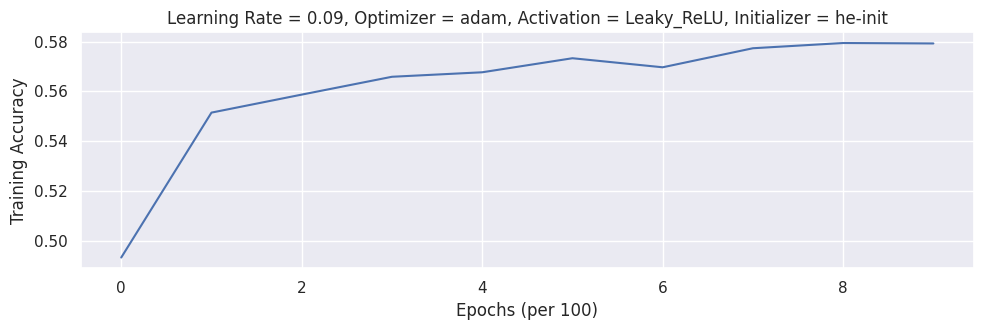

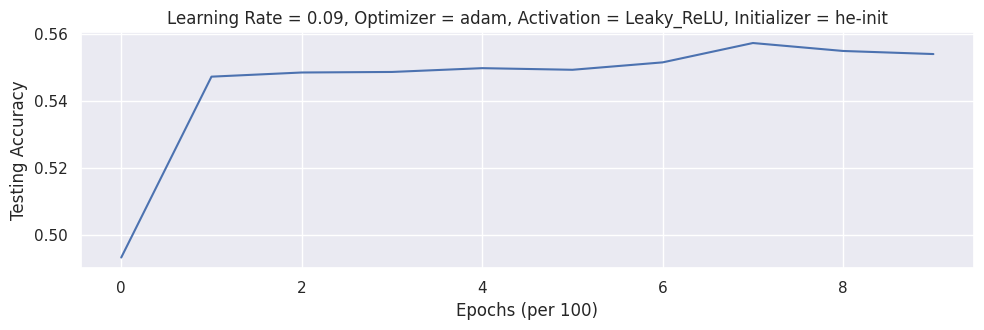

Training RMSE: 0.7133848686775379
Testing RMSE: 0.720975533879839


In [3]:
if __name__ == "__main__":
    nn = NeuralNetwork('https://raw.githubusercontent.com/YaswanthAdari/Gradient_descent_/main/dota2.csv')
    nn.data_preprocessing()
    nn.calculate_correlation()
    nn.split_data()
    nn.save_data()
    train_X, train_Y, test_X, test_Y = nn.load_training_data()
#     print(train_X.shape)
#     print(train_Y.shape)
#     print(test_X.shape)
#     print(test_Y.shape)
    layers_dims = [train_X.shape[0], 10, 10, 1]
    nn.NeuralNetworkModel(layers_dims, learning_rate = 0.09, num_epochs = 1000, optimizer = "adam", intializer = "he-init", activation = "Leaky_ReLU", beta1 = 0.9, beta2 = 0.99, epsilon = 1e-8)
 #   print()


## The below code iterates through all the possible combinations.

In [4]:
# if __name__ == "__main__":
#     nn = NeuralNetwork('https://raw.githubusercontent.com/YaswanthAdari/Gradient_descent_/main/dota2.csv')
#     nn.data_preprocessing()
#     #nn.calculate_correlation()
#     nn.split_data()
#     nn.save_data()
#     train_X, train_Y, test_X, test_Y = nn.load_training_data()
# #     print(train_X.shape)
# #     print(train_Y.shape)
# #     print(test_X.shape)
# #     print(test_Y.shape)

#     layers_dims = [train_X.shape[0], 10, 10, 1]
#     activations = ["Tanh", "Leaky_ReLU", "Sigmoid", "ReLU"]
#     lr = [0.07, 0.09, 0.1]
#     num_epochs = [2000, 5000]
#     initializerlist = [ "Zero", "Random", "Xavier"]

#     for i in activations:
#         for j in num_epochs:
#             for k in lr:
#                 for l in initializerlist:
#                     nn.NeuralNetworkModel(layers_dims, learning_rate = k, num_epochs=j, optimizer="gd", intializer=l, activation=i, beta1=0.9, beta2=0.99, epsilon=1e-8)

Cost after epoch 0: 18.185048
Cost after epoch 10: 0.843408
Cost after epoch 20: 0.730199
Cost after epoch 30: 0.703313
Cost after epoch 40: 0.695491
Cost after epoch 50: 0.693004
Cost after epoch 60: 0.692175
Cost after epoch 70: 0.691892
Cost after epoch 80: 0.691794
Cost after epoch 90: 0.691759
Cost after epoch 100: 0.691747
Cost after epoch 110: 0.691743
Cost after epoch 120: 0.691742
Cost after epoch 130: 0.691741
Cost after epoch 140: 0.691741
Cost after epoch 150: 0.691741
Cost after epoch 160: 0.691741
Cost after epoch 170: 0.691741
Cost after epoch 180: 0.691741
Cost after epoch 190: 0.691741
Cost after epoch 200: 0.691741
Cost after epoch 210: 0.691741
Cost after epoch 220: 0.691741
Cost after epoch 230: 0.691741
Cost after epoch 240: 0.691741


KeyboardInterrupt: ignored